In [94]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
from sklearn.metrics import *
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
 

import seaborn as sns

# Data about Instagram likes
Datasets
insta_train - train dataset
insta_test - test dataset
sample submission - example for submission
Target
likes - target column

Column description
user - users login in instagram
img - image url
caption - text in post
comments - comments count
language - caption language
hashtag - hashtag count
reference - how much references has post
caption_len - text length in post
language_encoded - language target encoded
username - username
posts - posts count
followers - followers count
followings - followings count
description - account description
photo_name - photo name
photo_path - photo local path
file_size - photo size in KB
id - unique md5 id for photo

In [95]:
train=pd.read_csv('./input/insta_train.csv', header=0)
test_X=pd.read_csv('./input/insta_test.csv', header=0)
train_Y=pd.DataFrame(train.likes)
train_X=train.drop(['likes'], axis=1)

In [96]:
test_X.info(), train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10435 entries, 0 to 10434
Data columns (total 18 columns):
user                10435 non-null object
img                 10435 non-null object
caption             9109 non-null object
comments            10435 non-null int64
language            10435 non-null object
hashtag             10435 non-null int64
reference           10435 non-null int64
caption_len         10435 non-null int64
language_encoded    10435 non-null float64
username            10435 non-null object
posts               10423 non-null float64
followers           10423 non-null float64
followings          10435 non-null int64
description         5709 non-null object
photo_name          10435 non-null object
photo_path          10435 non-null object
file_size           10435 non-null int64
id                  10435 non-null object
dtypes: float64(3), int64(6), object(9)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41540 entries, 0 to 41539
Da

(None, None)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


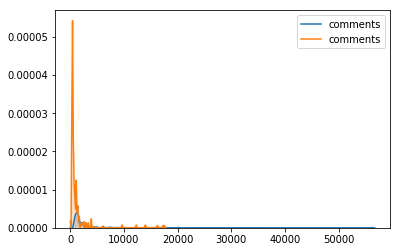

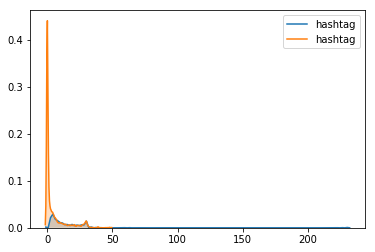

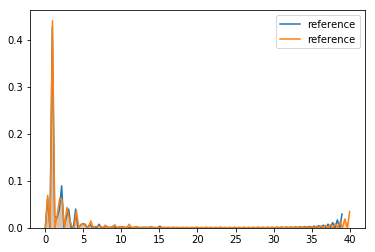

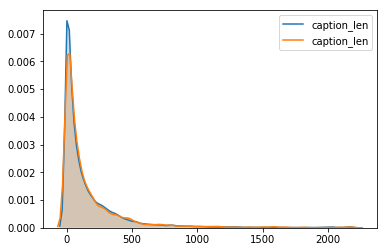

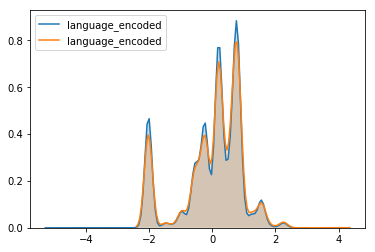

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


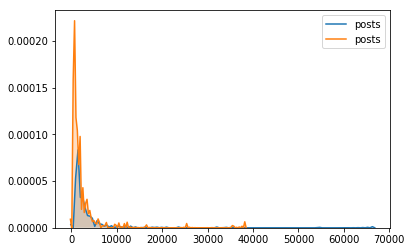

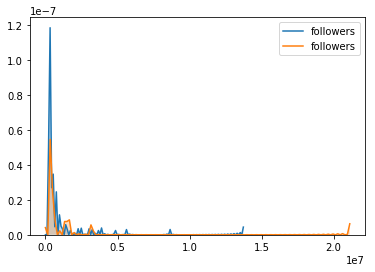

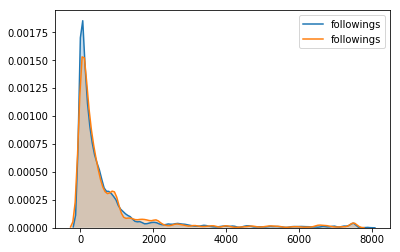

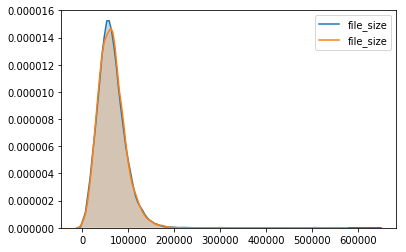

In [97]:
for i in train_X.select_dtypes(exclude='object').columns:
    sns.kdeplot((train_X[i]), shade=True)
    sns.kdeplot((test_X[i]), shade=True)
    plt.legend()
    plt.show()


In [98]:
train_X.isna().sum()

user                    0
img                     0
caption              5599
comments                0
language                0
hashtag                 0
reference               0
caption_len             0
language_encoded        0
username                0
posts                  12
followers              12
followings             12
description         19952
photo_name              0
photo_path              0
file_size               0
id                      0
dtype: int64

In [99]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41540 entries, 0 to 41539
Data columns (total 18 columns):
user                41540 non-null object
img                 41540 non-null object
caption             35941 non-null object
comments            41540 non-null int64
language            41540 non-null object
hashtag             41540 non-null int64
reference           41540 non-null int64
caption_len         41540 non-null int64
language_encoded    41540 non-null float64
username            41540 non-null object
posts               41528 non-null float64
followers           41528 non-null float64
followings          41528 non-null float64
description         21588 non-null object
photo_name          41540 non-null object
photo_path          41540 non-null object
file_size           41540 non-null int64
id                  41540 non-null object
dtypes: float64(4), int64(5), object(9)
memory usage: 5.7+ MB


In [100]:
le = preprocessing.LabelEncoder()
pol_feat=preprocessing.PolynomialFeatures(degree=2)

le.fit(pd.concat([train_X['language_encoded'], test_X['language_encoded']], axis=0))
train_X['language_encoded']=le.transform(train_X['language_encoded'])
test_X['language_encoded']=le.transform(test_X['language_encoded'])

In [101]:
def ing(df):
    
    pol_feat=preprocessing.PolynomialFeatures(degree=2)
        
    df['user_activity']=df.groupby(['user'])['user'].transform('count')
    df['fol'] = df['followers']/(df['followings']+1)
    df['act'] = df['comments']/(df['followers']+1)
    df['pos'] = df['posts']/(df['followers']+1)
    df['hashtag_max'] = df.groupby('user')['hashtag'].transform('max')
    df['hashtag_min'] = df.groupby('user')['hashtag'].transform('min')
    df['hashtag_mean'] = df.groupby('user')['hashtag'].transform('mean')
    df['hashtag_std'] = df.groupby('user')['hashtag'].transform('std')
    df['comments_max'] = df.groupby('user')['comments'].transform('max')
    df['comments_min'] = df.groupby('user')['comments'].transform('min')
    df['comments_mean'] = df.groupby('user')['comments'].transform('mean')
    df['comments_std'] = df.groupby('user')['comments'].transform('std')
    
     
     
    #pol_feat_df=pd.DataFrame(pol_feat.fit_transform(df[['user_activity','fol', 'act', 'pos']].fillna(-999)))
    #df = pd.concat([df, pol_feat_df], axis=1)
    
    return df

In [103]:
train_X=ing(train_X)
test_X=ing(test_X)

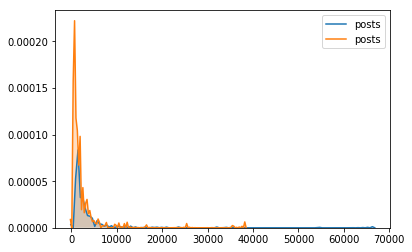

In [75]:
sns.kdeplot((train_X['posts']), shade=True)
sns.kdeplot((test_X['posts']), shade=True)
plt.legend()
plt.show()

In [106]:
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False) # transformation of input fetatures to Gausian distribution

def trf(df_train, df_test):
    for col in df_train.select_dtypes(exclude='object').columns:
        if col!=('user_activity') and ('language_encoded'):
            df_train[col]=pt.fit_transform(df_train[col].values.reshape(-1, 1)+1)
            df_test[col]=pt.transform(df_test[col].values.reshape(-1, 1)+1)
    return df_train, df_test
    

In [107]:
train_X.select_dtypes(exclude='object').columns

Index(['comments', 'hashtag', 'reference', 'caption_len', 'language_encoded',
       'posts', 'followers', 'followings', 'file_size', 'user_activity', 'fol',
       'act', 'pos', 'hashtag_max', 'hashtag_min', 'hashtag_mean',
       'hashtag_std', 'comments_max', 'comments_min', 'comments_mean',
       'comments_std'],
      dtype='object')

In [108]:
train_X, test_X = trf(train_X, test_X)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


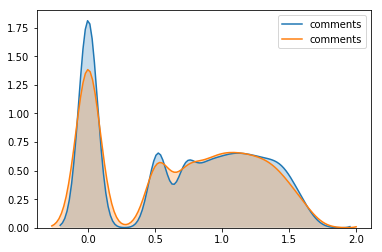

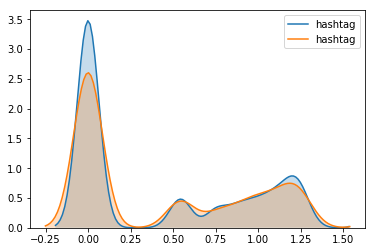

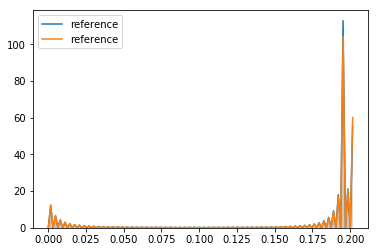

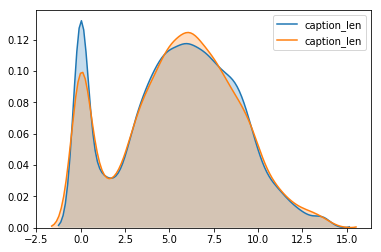

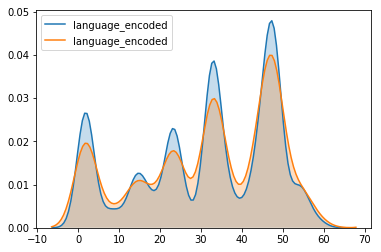

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


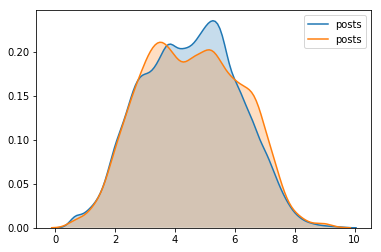

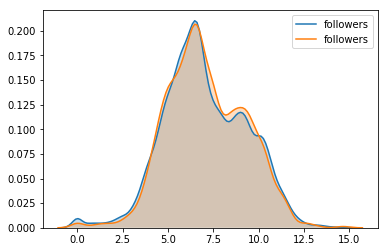

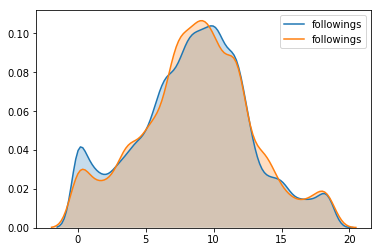

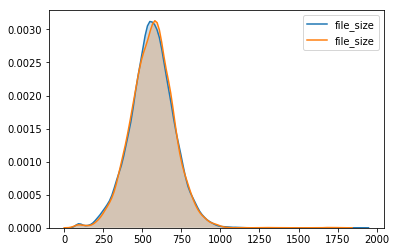

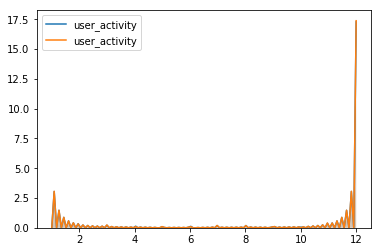

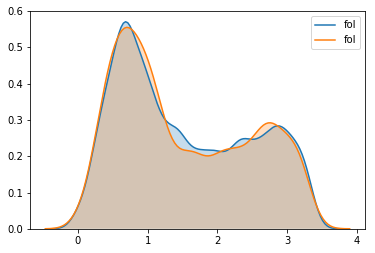

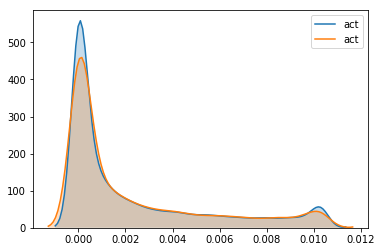

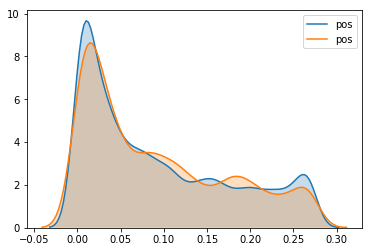

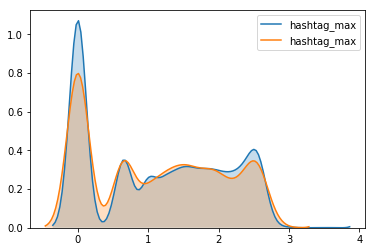

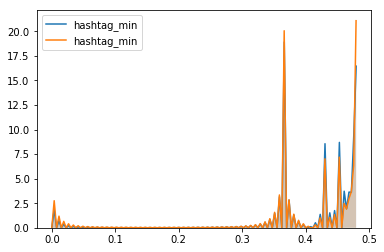

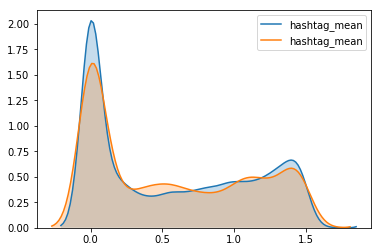

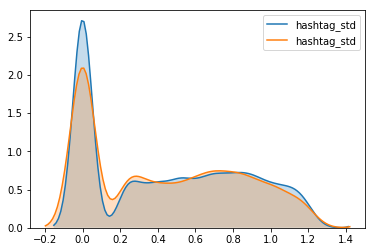

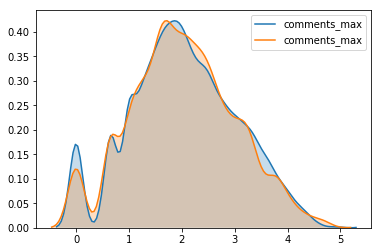

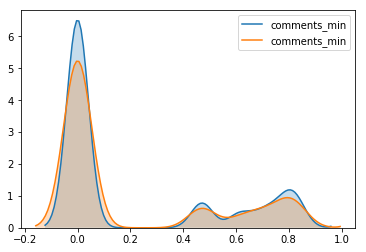

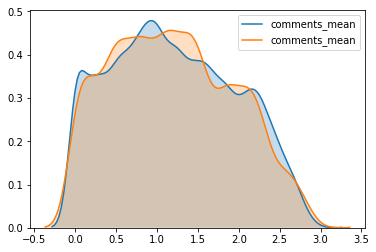

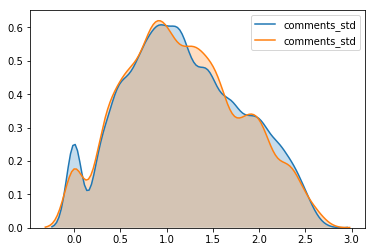

In [109]:
for i in train_X.select_dtypes(exclude='object').columns:
    sns.kdeplot((train_X[i]), shade=True)
    sns.kdeplot((test_X[i]), shade=True)
    plt.legend()
    plt.show()

In [111]:
train_X.info()

In [ ]:
train_X.select_dtypes(exclude=['object']).info()

In [164]:
import lightgbm as lgb

x_t, x_v, y_t, y_v = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)

#y_t.loc[y_t['likes']>25000, ['likes']]=25000
#train_Y.loc[train_Y['likes']>train_Y.likes.mean()+train_Y.likes.std(), ['likes']]=train_Y.likes.mean()+train_Y.likes.std()

train_full=lgb.Dataset(train_X.select_dtypes(exclude=['object']), label=train_Y,categorical_feature=['user_activity','language_encoded'], free_raw_data=False)

train_data = lgb.Dataset(x_t.select_dtypes(exclude=['object']), label=y_t, categorical_feature=['user_activity','language_encoded'], free_raw_data=False)
validation_data=lgb.Dataset(x_v.select_dtypes(exclude=['object']), label=y_v, reference=train_data, categorical_feature=['user_activity','language_encoded'])



params = {}
params['learning_rate'] = 0.015
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = ['None']
params['sub_feature'] = 0.8
params['num_leaves'] = 31
params['num_threads']= 8
params['min_data_in_leaf'] = 500
params['max_depth'] = 10
params['lambda_l1']=1.2
params['lambda_l2']=1.2
params['reg_sqrt']=True
params['num_round']=100
params['bagging_fraction']=0.8
params['bagging_freq']=1

def smape_score(y_pred, data):
    y_true = data.get_label()
    N=y_pred.size
    Smape=(200/N)*sum(abs(y_pred-y_true)/(abs(y_pred)+abs(y_true)))
    
    return 'smape', Smape, False

In [165]:
#num_round = 500
bst = lgb.train(params, train_data, valid_sets=[train_data, validation_data], early_stopping_rounds=100, feval=smape_score)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's smape: 131.049	valid_1's smape: 131.54
Training until validation scores don't improve for 100 rounds.
[2]	training's smape: 130.308	valid_1's smape: 130.818
[3]	training's smape: 129.562	valid_1's smape: 130.079
[4]	training's smape: 128.82	valid_1's smape: 129.355
[5]	training's smape: 128.085	valid_1's smape: 128.63
[6]	training's smape: 127.372	valid_1's smape: 127.918
[7]	training's smape: 126.652	valid_1's smape: 127.207
[8]	training's smape: 125.961	valid_1's smape: 126.516
[9]	training's smape: 125.25	valid_1's smape: 125.809
[10]	training's smape: 124.561	valid_1's smape: 125.124
[11]	training's smape: 123.871	valid_1's smape: 124.43
[12]	training's smape: 123.188	valid_1's smape: 123.744
[13]	training's smape: 122.523	valid_1's smape: 123.063
[14]	training's smape: 121.848	valid_1's smape: 122.376
[15]	training's smape: 121.173	valid_1's smape: 121.688
[16]	training's smape: 120.529	valid_1's smape: 121.032
[17]	training's smape: 119.872	valid_1's smape: 120.367

In [173]:
from sklearn.model_selection import GridSearchCV

gridParams = {
    'learning_rate': [0.01, 0.015, 0.03], 
    'num_leaves': [6, 8, 12, 16, 31], # large num_leaves helps improve accuracy but might lead to over-fitting
    'max_depth': [4, 6, 8, 10],
    
    'num_round' : [1000],
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    
        #    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
        #    'random_state' : [500],
    
#     'sub_feature' : [0.5, 0.65, 0.8],
#     'bagging_fraction' : [0.7, 0.75, 0.9],
#     'reg_alpha' : [1,1.2],
#     'lambda_l1' : [0, 1, 1.2],
#     'lambda_l2' : [0, 1, 1.2],
#     'min_data_in_leaf' : [100, 300, 900]
}

lgbm_model=lgb.LGBMRegressor()
grid = GridSearchCV(lgbm_model, gridParams, verbose=1, cv=5, n_jobs=-1)

# Run the grid
grid.fit(train_X.select_dtypes(exclude=['object']), train_Y)



Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.1min


KeyboardInterrupt: 

In [142]:
bst.best_iteration

5000

In [155]:
lgb.cv(params, train_full, num_round, nfold=5, feval=smape_score, show_stdv=False)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'smape-mean': [132.9384140860982,
  132.31086441576556,
  131.6736166084439,
  131.0491474399564,
  130.42927920012005,
  129.82307156829563,
  129.21028616632404,
  128.63175446652485,
  128.02763226892418,
  127.44801975870732,
  126.84994039023363,
  126.25405004149721,
  125.67726837445159,
  125.09108085660318,
  124.50927574678094,
  123.93718569927621,
  123.36224309838099,
  122.80142377334387,
  122.22662900851014,
  121.65487182995994,
  121.08850978972637,
  120.52611940457238,
  119.9652087515517,
  119.40734249905093,
  118.85172468476813,
  118.29961991346245,
  117.7450992104547,
  117.19990457674461,
  116.65426275774982,
  116.10935557275702,
  115.56798470067606,
  115.03155191654768,
  114.49628553373933,
  113.96666122384747,
  113.44839234630112,
  112.920942499701,
  112.39484838050589,
  111.8777939475415,
  111.36074375789103,
  110.84538375603843,
  110.3363330642787,
  109.82462163629816,
  109.31419337400848,
  108.818374971851,
  108.3116512059398,
  107.81

In [ ]:
test_X.info()

In [138]:
y_pred=bst.predict(x_v.select_dtypes(exclude=['object']), iter=bst.best_iteration)

In [139]:
y_pred[y_pred<0]

array([-8.61852285e-02, -9.99369094e-02, -5.55116095e-02, -2.69322773e+01,
       -1.76552485e+01, -3.15715057e-01, -4.58318161e-03, -3.25366961e-05,
       -5.96516497e-02, -2.14931620e-01, -2.90862395e-01, -9.76300764e-02,
       -2.81530650e+02, -1.10849768e+01, -2.48536731e-04, -9.62389925e+01,
       -2.29562024e+02, -1.39269247e-01, -1.64901453e-01, -2.24679746e+01,
       -9.08932523e-03, -3.43593986e-02])

In [140]:
#SMAPE Description
y_v=y_v.values.reshape(y_pred.shape)
N=y_pred.size
Smape=(200/N)*sum(abs(y_pred-y_v)/(abs(y_pred)+abs(y_v)))
Smape

AttributeError: 'numpy.ndarray' object has no attribute 'values'

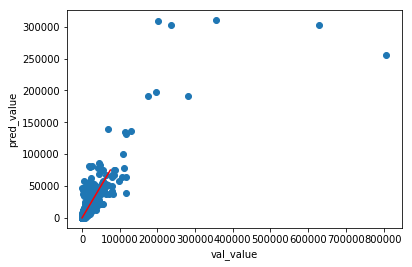

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216D2487AC8>]],
      dtype=object)

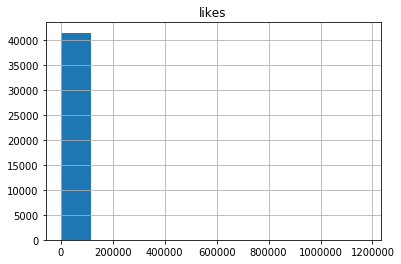

In [141]:
plt.figure()
plt.scatter(y_v, y_pred)
plt.plot([0,75000], [0,75000], color='red')

plt.xlabel("val_value")
plt.ylabel('pred_value')
plt.show()

train_Y.hist()

In [143]:
y_pred=bst.predict(test_X.select_dtypes(exclude=['object']), iter=bst.best_iteration)
prediction = pd.read_csv('./input/sample_submission.csv')

prediction['likes'] = y_pred

prediction.to_csv('my_submission.csv', index=False)

In [ ]:
plt.hist(y_pred)